## CS5284 Graph Machine Learning

## Coding sample

*Instructions* <br>
Name: Please, add your name here : e.g. JOHN SMITH<br>
Answers: Please write your answers directly in this notebook by completing the code sections marked with  
`# YOUR CODE STARTS HERE`  
`# YOUR CODE` (it can span one or multiple lines)  
`# YOUR CODE ENDS HERE`. <br>
Remark: If certain conditions of the questions (for eg. hyperparameter values) are not stated, you are free to choose anything you want.  


# Exercise : Graph Clustering with World Happiness Dataset

## Import libraries and utility functions

In [1]:
%reset -f
import datetime
print('Timestamp:',datetime.datetime.now().strftime("%y-%m-%d--%H-%M-%S"))
import numpy as np
import scipy.sparse
import pandas as pd
import sklearn.metrics.pairwise
import networkx as nx
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_ncut
from lib.utils import interactive_vis_graph
from lib.utils import print_neighboring_countries
from lib.utils import get_same_label_countries


Timestamp: 25-09-17--14-20-17


## Load and visualize the dataset

In [2]:
wh = pd.read_csv("datasets/2019.csv") # load the dataset
# Features GDP per capita, Social support, Healthy life expectancy, Freedom to make life choices, Generosity, Perceptions of corruption
data = wh.iloc[:,3:].to_numpy()
print('Number of data points is', data.shape[0], 'and the number of features is', data.shape[1])
print('\nFirst three data points:\n', str(data[:3]))
print('\nData statistics:')
wh.describe()


Number of data points is 156 and the number of features is 6

First three data points:
 [[1.34  1.587 0.986 0.596 0.153 0.393]
 [1.383 1.573 0.996 0.592 0.252 0.41 ]
 [1.488 1.582 1.028 0.603 0.271 0.341]]

Data statistics:


Overall rank       Score  GDP per capita  Social support  \
count    156.000000  156.000000      156.000000      156.000000   
mean      78.500000    5.407096        0.905147        1.208814   
std       45.177428    1.113120        0.398389        0.299191   
min        1.000000    2.853000        0.000000        0.000000   
25%       39.750000    4.544500        0.602750        1.055750   
50%       78.500000    5.379500        0.960000        1.271500   
75%      117.250000    6.184500        1.232500        1.452500   
max      156.000000    7.769000        1.684000        1.624000   

       Healthy life expectancy  Freedom to make life choices  Generosity  \
count               156.000000                    156.000000  156.000000   
mean                  0.725244                      0.392571    0.184846   
std                   0.242124                      0.143289    0.095254   
min                   0.000000                      0.000000    0.000000   
25%                   0.547750                      0.308000    0.108750   
50%                   0.789000                      0.417000    0.177500   
75%                   0.881750                      0.507250    0.248250   
max                   1.141000                      0.631000    0.566000   

       Perceptions of corruption  
count                 156.000000  
mean                    0.110603  
std                     0.094538  
min                     0.000000  
25%                     0.047000  
50%                     0.085500  
75%                     0.141250  
max                     0.453000

## Question 1 : Data normalization

Normalize the dataset `data` so that it has a mean of zero and a standard deviation of one along each data dimension.

After normalization, print both the mean and standard deviation of the normalized dataset.

Hint: You can use the functions `numpy.mean()` and `numpy.std()` for this task.


In [3]:
##############################
# Normalize the matrix data with zero mean and unit standard deviation
# YOUR CODE STARTS HERE 
data = data - np.mean(data, axis=0)
data = data / np.std(data, axis=0)
print('data mean: ', np.mean(data, axis=0))
print('data std: ', np.std(data, axis=0))
# YOUR CODE ENDS HERE
##############################


data mean:  [-1.36642834e-16 -1.36642834e-16 -3.64380890e-16 -3.18833279e-16
  2.13504428e-16 -4.55476113e-17]
data std:  [1. 1. 1. 1. 1. 1.]


## Question 2: Construct a k-nearest neighbors (kNN) graph

Follow the instructions below to construct a k-nearest neighbors (kNN) graph from the given dataset.


In [4]:
def construct_knn_graph(M, k):
    """Construct a graph using KNN
    Args:
        M: Data matrix as ndarray of size [n, d], n being the number of data points, d the number of features
        k: the number of nearest neighbors
    Return:
        A: Adjacency graph as scipy.sparse matrix of size [n, n]
    """

    # `dist_mat` is a n x n matrix with the pairwise distance between the data points
    dist_mat = sklearn.metrics.pairwise.pairwise_distances(M, metric='euclidean', n_jobs=1)
    dist_sorted = dist_mat.copy()
    ##############################
    # Instruction: Compute the n x k `dist_sorted` matrix, where each row contains the top k smallest distances for each data point.
    #              You may use function `numpy.sort()`.
    # YOUR CODE STARTS HERE
    dist_sorted = np.sort(dist_mat) # sort D from smallest to largest values
    dist_sorted = dist_sorted[:,:k]
    # YOUR CODE ENDS HERE
    ##############################

    # Adjacency matrix values `adj_val`
    sigma2 = np.mean(dist_sorted[:,-1])**2 # graph scale
    adj_val = np.exp(- dist_sorted**2 / sigma2)

    # Compute the n x n sparse adjacency matrix `A`
    n = M.shape[0]
    ##############################
    # Instruction: Compute the row and column indices, `row_idx` and `col_idx`, for each edge in the adjacency matrix.
    #              You may use functions `numpy.arange()` and `numpy.argsort()` and `numpy.reshape()`.
    # YOUR CODE STARTS HERE 
    row_idx = np.arange(0, n).repeat(k)
    idx = np.argsort(dist_mat)[:,:k] # indices of k nearest neighbors
    col_idx = idx.reshape(n*k)
    # YOUR CODE ENDS HERE
    ##############################
    data = adj_val.reshape(n*k)
    A = scipy.sparse.csr_matrix((data, (row_idx, col_idx)), shape=(n, n))

    # Make A symmetric
    bigger = A.T > A
    A = A - A.multiply(bigger) + A.T.multiply(bigger)

    return A
    

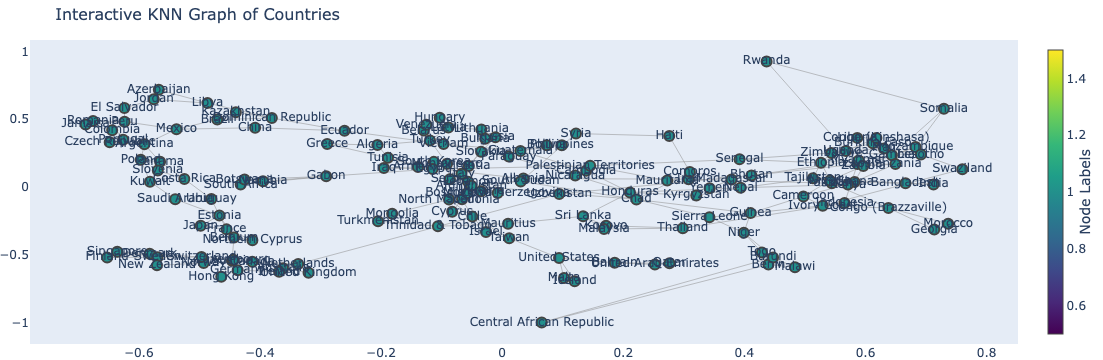

Neighboring countries of Finland:
- Denmark
- Sweden
Neighboring countries of Thailand:
- Kosovo
- Malaysia
- Indonesia
Neighboring countries of Singapore:
- Denmark
- Sweden


In [5]:
# Construct the graph
A = construct_knn_graph(data, k=3)

# Visualize the graph of countries 
countries = wh.iloc[:,1].values
labels = dict(zip(range(data.shape[0]), countries))
G_nx = nx.from_scipy_sparse_array(A)
G_nx.remove_edges_from(nx.selfloop_edges(G_nx)) # Remove self-loops
interactive_vis_graph(G_nx, countries, np.ones(data.shape[0]))
print_neighboring_countries(G_nx, countries, 'Finland')
print_neighboring_countries(G_nx, countries, 'Thailand')
print_neighboring_countries(G_nx, countries, 'Singapore')


## Question 3: Compute and visualize clusters of similar countries according to the features

Identify at least three countries that belong to the same cluster as Singapore.

Hint: Use the `get_same_label_countries(countries, C, 'Singapore')` function to display the countries in the same cluster as Singapore.


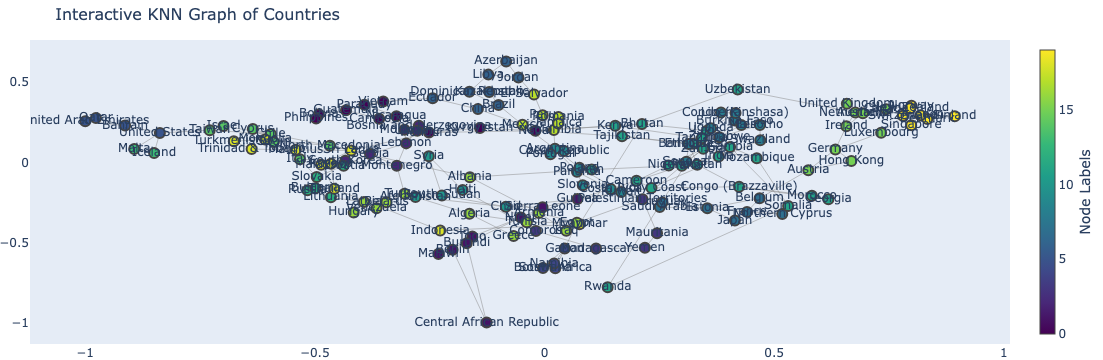

Countries in the same cluster as Singapore: ['Finland', 'Denmark', 'Norway', 'Switzerland', 'Sweden', 'New Zealand']


In [7]:
C, _ = compute_ncut(A, np.ones(data.shape[0]), 20)
interactive_vis_graph(G_nx, countries, C)
##############################
# YOUR CODE STARTS HERE 
get_same_label_countries(countries, C, 'Singapore')
# YOUR CODE ENDS HERE
##############################


## End of coding test